In [1]:
import numpy as np
from numpy import float32,int32
np.random.seed(42)
import tensorflow as tf
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
import seaborn as sns
from numpy import mean
from numpy import std
from numpy import dstack
from keras import optimizers

tf.set_random_seed(42)
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout,Permute,Reshape
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM, Dense, Embedding, Flatten, RepeatVector, TimeDistributed, Concatenate
from keras.callbacks import TensorBoard, ModelCheckpoint
import os
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
%matplotlib inline
matplotlib.style.use('ggplot')
DATADIR = 'HARDataset'

SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    #"body_gyro_x",
    #"body_gyro_y",
    #"body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}


def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
                       
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

def load_signals(subset):
    signals_data = []
    for signal in SIGNALS:
        filename = '{0}/{1}/Inertial Signals/{2}_{3}.txt'.format(DATADIR,subset,signal,subset)
        signals_data.append(
            _read_csv(filename).as_matrix()
        )
    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = '{0}/{1}/y_{2}.txt'.format(DATADIR,subset,subset)
    y = _read_csv(filename)[0]
    return pd.get_dummies(y).as_matrix()


def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')
    print(X_train.shape)
    return X_train, X_test, y_train, y_test

LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
lables=np.array(LABELS)

def one_hot(y_):
    """
    Function to encode output labels from number indexes.
    E.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    """
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

def _count_classes(y):
    return len(set([tuple(category) for category in y]))



Using TensorFlow backend.


C:\Users\User\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\User\Miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:87: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(7352, 128, 6)
Train on 5881 samples, validate on 1471 samples
Epoch 1/50
5881/5881 [==============================] - 5s 915us/step - loss: 0.8856 - acc: 0.6285 - val_loss: 0.5863 - val_acc: 0.8416
Epoch 2/50
5881/5881 [==============================] - 4s 626us/step - loss: 0.3265 - acc: 0.8653 - val_loss: 0.5281 - val_acc: 0.8702
Epoch 3/50
5881/5881 [==============================] - 4s 753us/step - loss: 0.2463 - acc: 0.8927 - val_loss: 0.4178 - val_acc: 0.8906
Epoch 4/50
5881/5881 [==============================] - 4s 760us/step - loss: 0.2016 - acc: 0.9123 - val_loss: 0.4218 - val_acc: 0.8926
Epoch 5/50
5881/5881 [==============================] - 5s 801us/step - loss: 0.1798 - acc: 0.9233 - val_loss: 0.3462 - val_acc: 0.9157
Epoch 6/50
5881/5881 [==============================] - 5s 813us/step - loss: 0.1507 - acc: 0.9364 - val_loss: 0.3491 - val_acc: 0.9171
Epoch 7/50
5881/5881 [==============================] - 5s 793us/step - loss: 0.1405 - acc: 0.9354 - val_loss: 0.5184 - v

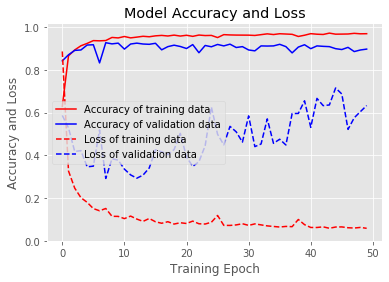

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 494        0         0        0                   1   
SITTING                  0      397        69        0                   0   
STANDING                 0      100       426        0                   0   
WALKING                  0        0         0      454                  26   
WALKING_DOWNSTAIRS       0        0         0        4                 415   
WALKING_UPSTAIRS         0        0         0       35                  24   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            42  
SITTING                           25  
STANDING                           6  
WALKING                           16  
WALKING_DOWNSTAIRS                 1  
WALKING_UPSTAIRS                 412  


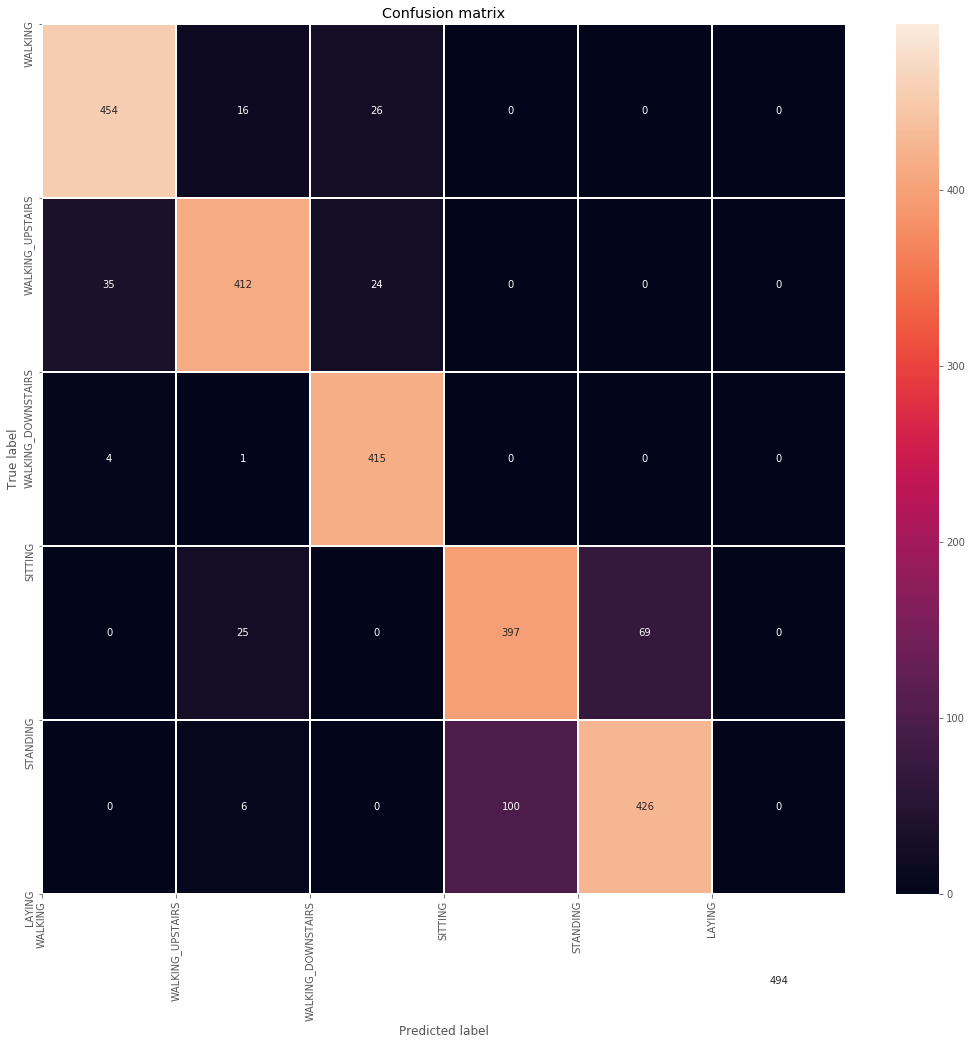

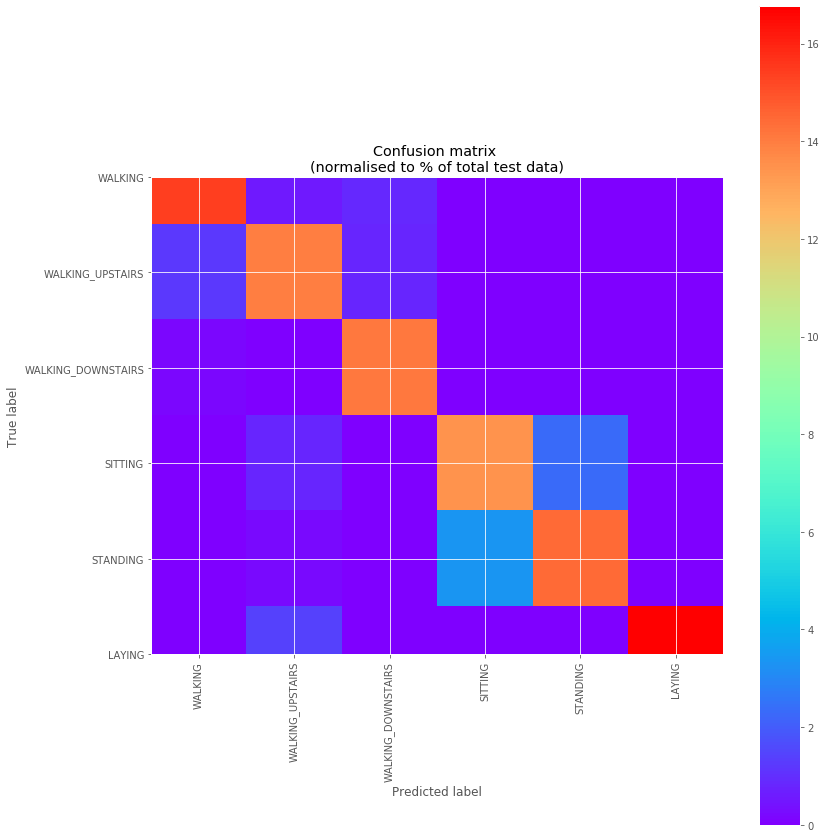

2947/2947 [==============================] - 0s 160us/step
0.8815744902912058
>#1: 88.157
[88.15744902912058]
Accuracy: 88.157% (+/-0.000)


In [2]:
# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
    
# run an experiment
def run_experiment(repeats=1):
	# repeat experiment
	scores = list()
	for r in range(repeats):
		X_train, X_test, Y_train, Y_test = load_data()
		y_test=Y_test.argmax(1)
		timesteps = len(X_train[0])
		input_dim = len(X_train[0][0])
		n_classes = _count_classes(Y_train)
		tick_marks = np.arange(n_classes)
		# fit and evaluate a model
		verbose, epochs, batch_size, validation_split = 1, 50, 50, 0.2
		model = Sequential()
		model.add(Conv1D(filters=20, kernel_size=3, activation='relu'))
		model.add(MaxPooling1D(pool_size=2))
		model.add(Conv1D(filters=20, kernel_size=3, activation='relu'))
		model.add(MaxPooling1D(pool_size=2))
		model.add(Conv1D(filters=20, kernel_size=3, activation='relu'))
		model.add(MaxPooling1D(pool_size=2))
		model.add(Conv1D(filters=20, kernel_size=3, activation='relu'))
		model.add(MaxPooling1D(pool_size=2))        
		#model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
		model.add(Bidirectional(LSTM(100)))
		model.add(Dropout(0.5))
		model.add(Dense(100, activation='relu'))
		#model.add(Dense(n_outputs, activation='softmax'))
		model.add(Dense(6, activation='softmax'))
		adam=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
		model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
		# fit network
		history=model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose,validation_split=0.2,shuffle=True)
		history_dict = history.history
		history_dict.keys()
		loss = history.history['loss']
		val_loss = history.history['val_loss'] 
		print(model.summary())
		plt.figure(figsize=(6, 4))
		plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
		plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
		plt.plot(history.history['loss'], 'r--', label='Loss of training data')
		plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
		plt.title('Model Accuracy and Loss')
		plt.ylabel('Accuracy and Loss')
		plt.xlabel('Training Epoch')
		plt.ylim(0)
		plt.legend()
		plt.show()
		# Evaluate
		print(confusion_matrix(Y_test, model.predict(X_test)))
		predict=model.predict(X_test)
		#print("predict#################",predict)
		pred_index_total=[]
		for pred in predict:
			pred_index = []
			pred_list=pred.tolist()
			index_max=pred_list.index(max(pred_list))
			pred_index.append(index_max)
			pred_index_total.append(np.array(pred_index))
		#print(pred_index_total)
		one_hot_predictions=one_hot(np.array(pred_index_total))
		#print("one_hot_predictions%%%%%%%%%",one_hot_predictions)
		prediction=one_hot_predictions.argmax(1)
		cm= metrics.confusion_matrix(y_test, prediction)
		#print("%%%%%%%%%%%%%%%",confusion_matrix)
		plt.figure(figsize=(18, 16))
		sns.heatmap(cm, linewidth=1,linecolor="white",xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
		plt.title("Confusion matrix")
		plt.xticks(tick_marks, LABELS, rotation=90)
		plt.yticks(tick_marks, LABELS)
		plt.ylabel('True label')
		plt.xlabel('Predicted label')
		plt.show();
		normalised_confusion_matrix = np.array(cm, dtype=float32)/np.sum(cm)*100
		plt.figure(figsize=(12, 12))
		plt.imshow(
			normalised_confusion_matrix,
			interpolation='nearest',
			cmap=plt.cm.rainbow
		)
		plt.title("Confusion matrix \n(normalised to % of total test data)")
		plt.colorbar()
		plt.xticks(tick_marks,lables,rotation=90)
		plt.yticks(tick_marks,lables)
		plt.tight_layout()
		plt.ylabel('True label')
		plt.xlabel('Predicted label')
		plt.show()
		_, accuracy = model.evaluate(X_test, Y_test, batch_size=200, verbose=1)
		print(accuracy)
		score = accuracy * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)
# run the experiment
run_experiment()